In [2]:
import numpy as np
import stim

# function to get the i'th bit of an integer n
def get_bit(n, i):
    return (n >> i) & 1

In [3]:
QRM_X_CHECKS = [
    [1,3,5,7,9,11,13,15],
    [2,3,6,7,10,11,14,15],
    [4,5,6,7,12,13,14,15],
    [8,9,10,11,12,13,14,15]
]

QRM_Z_CHECKS = [
    [ 1, 3, 5, 7, 0, 0],
    [ 3, 2, 7, 6, 0, 0],
    [ 2, 6,14,10, 0, 0],
    [ 6,14,12, 4, 0, 0],
    [13,12, 4, 5, 0, 0],
    [12, 8, 0,13, 9, 0],
    [ 8, 9,10,11, 0, 0],
    [ 9, 1,11, 3, 0, 0],
    [ 5, 7,13,15, 0, 0],
    [10,11,15,14, 0, 0],
    # redundancies
    [ 4, 5, 0, 0, 7, 6],
    [14, 0, 8, 0,10,12],
    [ 0, 0, 9, 1, 5,13],
    [ 0,10, 2, 0,11, 3],
    [ 0,15, 6, 0,14, 7],
    [15,13, 0, 0,12,14],
    [ 7, 0, 3, 0,15,11],
    [11, 0, 0, 9,13,15]
]

QRM_META_CHECKS = [
    [ 1,18, 8, 9],
    [ 1,18,13,17],
    [ 2,10,14,15],
    [ 2,10, 3,17],
    [ 5,15, 4, 9],
    [ 5,15,11,16],
    [ 7,16, 6,10],
    [ 7,16,12,18],
]

for sublist in QRM_Z_CHECKS:
    binary_sublist = [bin(x)[2:].zfill(4) for x in sublist]
    print(binary_sublist)

['0001', '0011', '0101', '0111', '0000', '0000']
['0011', '0010', '0111', '0110', '0000', '0000']
['0010', '0110', '1110', '1010', '0000', '0000']
['0110', '1110', '1100', '0100', '0000', '0000']
['1101', '1100', '0100', '0101', '0000', '0000']
['1100', '1000', '0000', '1101', '1001', '0000']
['1000', '1001', '1010', '1011', '0000', '0000']
['1001', '0001', '1011', '0011', '0000', '0000']
['0101', '0111', '1101', '1111', '0000', '0000']
['1010', '1011', '1111', '1110', '0000', '0000']
['0100', '0101', '0000', '0000', '0111', '0110']
['1110', '0000', '1000', '0000', '1010', '1100']
['0000', '0000', '1001', '0001', '0101', '1101']
['0000', '1010', '0010', '0000', '1011', '0011']
['0000', '1111', '0110', '0000', '1110', '0111']
['1111', '1101', '0000', '0000', '1100', '1110']
['0111', '0000', '0011', '0000', '1111', '1011']
['1011', '0000', '0000', '1001', '1101', '1111']


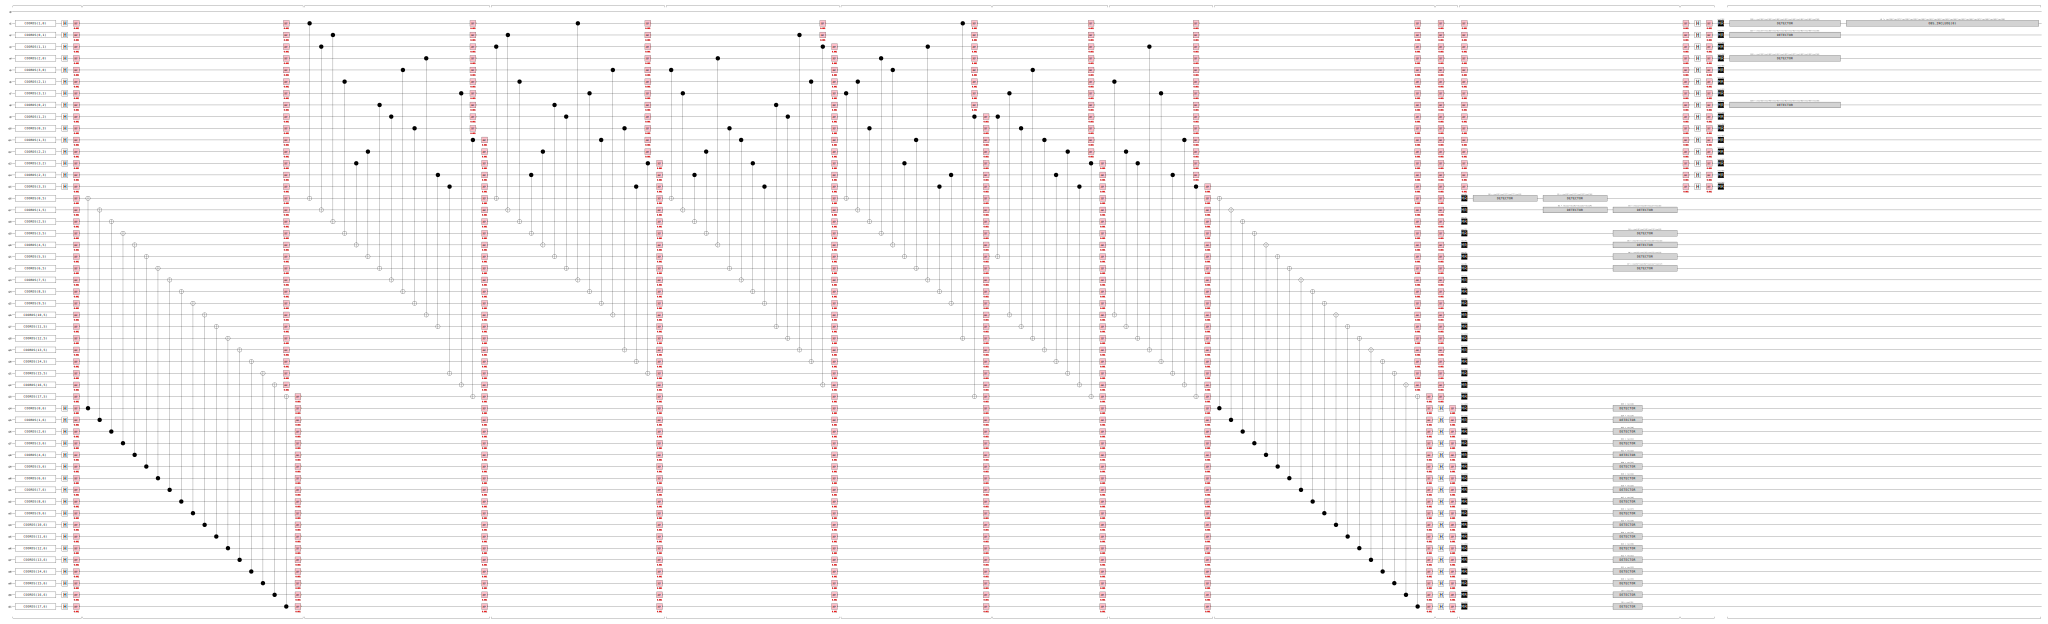

In [4]:
def qrm_circuit_flag(error_rate=0.01):
    """
    Returns a QRM circuit with depolarizing noise applied.
    The error rate can be adjusted.
    """
    circuit = stim.Circuit()
    for i in range(1, 16):
        circuit.append("QUBIT_COORDS", [i], [get_bit(i,0) + 2 * get_bit(i,2), get_bit(i,1) + 2 * get_bit(i,3)])
    for j in range(16,34):
        circuit.append("QUBIT_COORDS", [j], [j - 16, 5])
    for j in range(34,52):
        circuit.append("QUBIT_COORDS", [j], [j - 34, 6])

    # initialize data qubits, ancilla qubits and flags
    circuit.append('H', list(range(1, 16)))
    circuit.append('H', list(range(34, 52)))
    circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
    circuit.append('TICK')

    # one round of stabilizer measurements
    for i in range(6):
        if i == 0:
            for j in range(18):
                circuit.append('CNOT', [34 + j, 16 + j])
            circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
            circuit.append('TICK')
        for j in range(18):
            qubit = QRM_Z_CHECKS[j][i]
            if qubit != 0:
                circuit.append('CNOT', [qubit, 16 + j])
        circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
        circuit.append('TICK')
        if i == 5:
            for j in range(18):
                circuit.append('CNOT', [34 + j, 16 + j])
            circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
            circuit.append('TICK')
            circuit.append('H', list(range(34,52)))
            circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
            circuit.append('TICK')
    circuit.append('MR', list(range(16, 52)))
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])


    # metachecks
    for mc in QRM_META_CHECKS:
        mc = [c - 37 for c in mc]
        circuit.append('DETECTOR', [stim.target_rec(mc[0]),stim.target_rec(mc[1]),stim.target_rec(mc[2]),stim.target_rec(mc[3])])

    # check flags
    for j in range(18):
        circuit.append('DETECTOR', [stim.target_rec(-j-1)]) 
    circuit.append('TICK')

    # final measurements
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])
    circuit.append('H', list(range(1, 16)))
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])
    circuit.append('TICK')

    circuit.append('MR', list(range(1, 16)))
    circuit.append('TICK')
    
    # readout checks
    for stabilizer in QRM_X_CHECKS:
        circuit.append('DETECTOR', [stim.target_rec(i - 16) for i in stabilizer])
    
    # readout logical X
    circuit.append('OBSERVABLE_INCLUDE', [stim.target_rec(i - 15) for i in range(15)], 0)

    return circuit

circuit = qrm_circuit_flag(error_rate=0.001)
# circuit.without_noise().diagram('timeline-3d')
# circuit.without_noise().diagram('timeslice-svg')
circuit.diagram('timeline-svg')

[-6.457775907873672, -6.059260945398487, -5.4124531671153475, -4.781324804480712, -4.321818704082481, -3.8375096761423593, -3.361572351709554, -2.829025197269877, -2.300083306593107, -1.812636703778707] [0.8607899, 0.802341, 0.7237877, 0.6225325, 0.4993392, 0.3611345, 0.2250894, 0.11299, 0.0416092, 0.0098867]


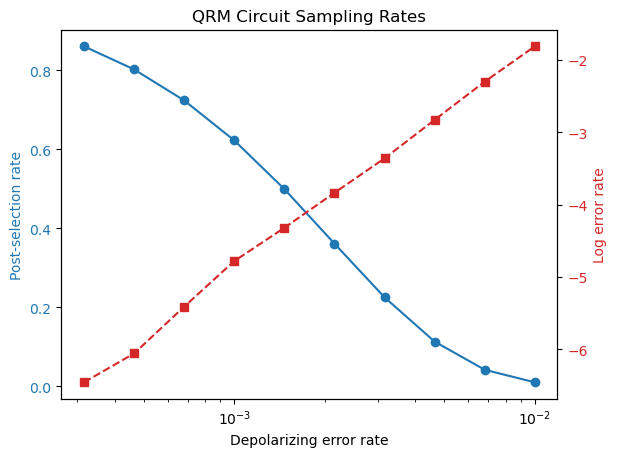

In [30]:
import matplotlib.pyplot as plt

def qrm_sampling(error_rate=0.01, N=200000):
    """
    Samples the QRM circuit with depolarizing noise.
    The error rate can be adjusted.
    Returns the post-selection rate and the error rate.
    """
    circuit = qrm_circuit_flag(error_rate)
    
    sampler = circuit.compile_sampler()
    converter = circuit.compile_m2d_converter()
    detector_samples = converter.convert(measurements=sampler.sample(N), append_observables=True)
    
    N_true = (detector_samples.sum(axis=1) == 0).sum()
    N_post = (detector_samples[:, :-1].sum(axis=1) == 0).sum()
    
    post_selection_rate = N_post / N
    log_error_rate = np.log10(1 - N_true / N_post)
    
    return post_selection_rate, log_error_rate

error_rates = [10**(x) for x in np.linspace(-3.5, -2, 10)]
post_selection_rates = []
log_error_rates = []
for error_rate in error_rates:
    post_selection_rate, log_error_rate = qrm_sampling(error_rate, N=int(1e7))
    post_selection_rates.append(post_selection_rate)
    log_error_rates.append(log_error_rate)

print(log_error_rates, post_selection_rates)
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Depolarizing error rate')
ax1.set_ylabel('Post-selection rate', color=color)
ax1.plot(error_rates, post_selection_rates, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Log error rate', color=color)
ax2.plot(error_rates, log_error_rates, 's--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('QRM Circuit Sampling Rates')
plt.show()

Actually, the simulation above exaggerates the idling error.

In [5]:
def qrm_circuit_flag(error_rate=0.01):
    """
    Returns a QRM circuit with depolarizing noise applied.
    The error rate can be adjusted.
    """
    circuit = stim.Circuit()
    for i in range(1, 16):
        circuit.append("QUBIT_COORDS", [i], [get_bit(i,0) + 2 * get_bit(i,2), get_bit(i,1) + 2 * get_bit(i,3)])
    for j in range(16,34):
        circuit.append("QUBIT_COORDS", [j], [j - 16, 5])
    for j in range(34,52):
        circuit.append("QUBIT_COORDS", [j], [j - 34, 6])

    # initialize data qubits, ancilla qubits and flags
    circuit.append('H', list(range(1, 16)))
    circuit.append('H', list(range(34, 52)))
    circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
    circuit.append('TICK')

    # one round of stabilizer measurements
    for i in range(6):
        if i == 0:
            for j in range(18):
                circuit.append('CNOT', [34 + j, 16 + j])
                circuit.append("DEPOLARIZE1", [34 + j, 16 + j], [error_rate])
            circuit.append('TICK')
        for j in range(18):
            qubit = QRM_Z_CHECKS[j][i]
            if qubit != 0:
                circuit.append('CNOT', [qubit, 16 + j])
                circuit.append("DEPOLARIZE1", [qubit, 16 + j], [error_rate])
        circuit.append('TICK')
        if i == 5:
            for j in range(18):
                circuit.append('CNOT', [34 + j, 16 + j])
                circuit.append("DEPOLARIZE1", [34 + j, 16 + j], [error_rate])
            circuit.append('TICK')
            circuit.append('H', list(range(34,52)))
            circuit.append("DEPOLARIZE1", list(range(34,52)), [error_rate])
            circuit.append('TICK')
    circuit.append('X_ERROR', list(range(16, 52)), [error_rate])
    circuit.append('MR', list(range(16, 52)))


    # metachecks
    for mc in QRM_META_CHECKS:
        mc = [c - 37 for c in mc]
        circuit.append('DETECTOR', [stim.target_rec(mc[0]),stim.target_rec(mc[1]),stim.target_rec(mc[2]),stim.target_rec(mc[3])])

    # check flags
    for j in range(18):
        circuit.append('DETECTOR', [stim.target_rec(-j-1)]) 
    circuit.append('TICK')

    # one layer of gate
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])
    circuit.append('TICK')

    # final measurements
    circuit.append('H', list(range(1, 16)))
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])
    circuit.append('TICK')

    circuit.append('X_ERROR', list(range(1, 16)), [error_rate])
    circuit.append('MR', list(range(1, 16)))
    circuit.append('TICK')
    
    # readout checks
    for stabilizer in QRM_X_CHECKS:
        circuit.append('DETECTOR', [stim.target_rec(i - 16) for i in stabilizer])
    
    # readout logical X
    circuit.append('OBSERVABLE_INCLUDE', [stim.target_rec(i - 15) for i in range(15)], 0)

    return circuit

circuit = qrm_circuit_flag(error_rate=0.001)
# circuit.without_noise().diagram('timeline-3d')
# circuit.without_noise().diagram('timeslice-svg')
circuit.diagram('timeline-svg')
# output this circuit to a .stim file
circuit.to_file('circuits/qrm_flag_nogate_demo.stim')

In [6]:
circuit.diagram('matchgraph-3d')

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":3,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":4,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":5,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":6,"byteOffset":0,"componentType":5126,"count":736,"max":[21,24.5079135894775,-1],"min":[-10,-9.86393928527832,-1],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":7,"byteOffset":0,"componentType":5126,"count":496,"max":[28.592565536499,15,-1],"min":[3,-7.68221282958984,-1],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":1,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":2,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":3,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":4,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":5,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":6,"byteLength":8832,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":7,"byteLength":5952,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":8832,"name":"buf_scattered_lines","uri":"data:application/octet-stream;base64,AAAAAAAAAAAAAIC/TfbywNRA0MAAAIC/AAAAAAAAAAAAAIC/AABAQAAAAAAAAIC/AAAAAAAAAAAAAIC/AABAQAAAAAAAAIC/AAAAAAAAQEAAAIC/AAAAAAAAwEAAAIC/AAAAAAAAAAAAAIC/AABAQAAAAAAAAIC/AAAAAAAAQEAAAIC/AAAAAAAAwEAAAIC/AAAQQQAAAAAAAIC/AADAQAAAQEAAAIC/AAAAAAAAAAAAAIC/AABAQAAAAAAAAIC/AAAAAAAAQEAAAIC/AAAAAAAAwEAAAIC/AAAQQ

In [7]:
import matplotlib.pyplot as plt

def qrm_sampling(error_rate=0.01, N=200000):
    """
    Samples the QRM circuit with depolarizing noise.
    The error rate can be adjusted.
    Returns the post-selection rate and the error rate.
    """
    circuit = qrm_circuit_flag(error_rate)
    
    sampler = circuit.compile_sampler()
    converter = circuit.compile_m2d_converter()
    detector_samples = converter.convert(measurements=sampler.sample(N), append_observables=True)
    
    N_true = (detector_samples.sum(axis=1) == 0).sum()
    N_post = (detector_samples[:, :-1].sum(axis=1) == 0).sum()
    
    post_selection_rate = N_post / N
    log_error_rate = np.log10(1 - N_true / N_post)
    
    return post_selection_rate, log_error_rate

error_rates = [10**(x) for x in np.linspace(-3.5, -2, 10)]
post_selection_rates = []
log_error_rates = []
for error_rate in error_rates:
    post_selection_rate, log_error_rate = qrm_sampling(error_rate, N=int(1e7))
    post_selection_rates.append(post_selection_rate)
    log_error_rates.append(log_error_rate)

print(log_error_rates, post_selection_rates)
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Depolarizing error rate')
ax1.set_ylabel('Post-selection rate', color=color)
ax1.plot(error_rates, post_selection_rates, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Log error rate', color=color)
ax2.plot(error_rates, log_error_rates, 's--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('QRM Circuit Sampling Rates')
plt.show()

KeyboardInterrupt: 

In [8]:
import numpy as np
from typing import Iterable

def make_postselection_mask(num_detectors: int, indices: Iterable[int]) -> np.ndarray:
    """
    Build a bit-packed uint8 mask for Sinter's postselection_mask.

    - Bit i corresponds to detector i (LSB-first within each byte).
    - Set bit i to 1 to postselect that detector (discard shots where it fires).

    Args:
        num_detectors: Total number of detectors in the DEM/circuit.
        indices: Iterable of detector indices to postselect on (0-based).

    Returns:
        np.ndarray of shape (ceil(num_detectors/8),) and dtype=np.uint8.
    """
    if num_detectors < 0:
        raise ValueError("num_detectors must be non-negative")
    nbytes = (num_detectors + 7) // 8
    mask = np.zeros(nbytes, dtype=np.uint8)

    idx = np.fromiter(indices, dtype=np.int64, count=-1)
    if idx.size == 0:
        return mask  # nothing to set

    if (idx < 0).any() or (idx >= num_detectors).any():
        bad = idx[(idx < 0) | (idx >= num_detectors)]
        raise ValueError(f"indices out of range: {bad.tolist()} for num_detectors={num_detectors}")

    byte_idx = (idx >> 3).astype(np.int64)
    bit_pos = (idx & 7).astype(np.uint8)
    vals = (1 << bit_pos).astype(np.uint8)

    # In-place OR accumulation handles duplicates correctly.
    np.bitwise_or.at(mask, byte_idx, vals)
    return mask


def estimate_ps_and_logical_error(
    circuit: stim.Circuit,
    *,
    attempts: int,
    postselection_mask: np.ndarray | None = None,
    chunk_size: int = 100_000,
):
    """
    Returns:
        A dict with:
            - attempted: total attempted shots
            - kept: shots that passed postselection
            - discards: shots rejected by postselection
            - postselection_rate: kept / attempted
            - logical_error_rate_cond_ps: per-observable rate among kept shots (np.ndarray, NaN if kept=0)
            - logical_error_rate_uncond: per-observable rate among all attempted shots (np.ndarray)
    """
    # if seed is None:
    #     rng_seed = np.random.SeedSequence().entropy
    # else:
    #     rng_seed = seed

    num_d = circuit.num_detectors
    num_o = circuit.num_observables

    if postselection_mask is None:
        # Default: postselect on all detectors
        postselection_mask = np.ones(num_d, dtype=bool)
    else:
        postselection_mask = np.asarray(postselection_mask, dtype=bool)
        if postselection_mask.shape != (num_d,):
            raise ValueError(f"postselection_mask must have length {num_d}")

    sampler = circuit.compile_detector_sampler()

    kept = 0
    discards = 0
    attempted = 0

    # Track errors both unconditional and conditional on postselection
    err_counts_uncond = np.zeros(num_o, dtype=np.int64) if num_o else None
    err_counts_cond = np.zeros(num_o, dtype=np.int64) if num_o else None

    remaining = attempts
    while remaining > 0:
        n = min(chunk_size, remaining)
        # Get detectors and observables for the same shots
        dets, obs = sampler.sample(n, separate_observables=True)  # dets: (n, num_d), obs: (n, num_o)

        # Postselection: keep if none of the selected detectors fired
        if postselection_mask.any():
            dets_ps = dets[:, postselection_mask]
            keep_mask = ~np.any(dets_ps, axis=1)
        else:
            # Empty mask means keep everything.
            keep_mask = np.ones(n, dtype=bool)

        k = int(np.count_nonzero(keep_mask))
        kept += k
        discards += (n - k)
        attempted += n

        if num_o:
            # Unconditional error counts
            err_counts_uncond += np.sum(obs, axis=0)
            # Conditional on postselection
            if k > 0:
                err_counts_cond += np.sum(obs[keep_mask, :], axis=0)

        remaining -= n

    ps_rate = kept / attempted if attempted > 0 else float('nan')

    if num_o:
        ler_uncond = err_counts_uncond / attempted
        ler_cond = (err_counts_cond / kept) if kept > 0 else np.full(num_o, np.nan)
    else:
        ler_uncond = np.empty((0,), dtype=float)
        ler_cond = np.empty((0,), dtype=float)

    return {
        'attempted': attempted,
        'kept': kept,
        'discards': discards,
        'postselection_rate': ps_rate,
        'logical_error_rate_cond_ps': ler_cond,
        'logical_error_rate_uncond': ler_uncond,
    }


In [ ]:
error_rates = [10**(x) for x in np.linspace(-3.5, -2, 10)]
post_selection_rates = []
log_error_rates = []
for error_rate in error_rates:
    circuit = qrm_circuit_flag(error_rate)
    stats = estimate_ps_and_logical_error(circuit, attempts=int(1e7))
    post_selection_rates.append(stats['postselection_rate'])
    log_error_rates.append(stats['logical_error_rate_cond_ps'])

print(log_error_rates, post_selection_rates)

[array([3.31535966e-07]), array([8.1050404e-07]), array([1.98432433e-06]), array([4.11440064e-06]), array([1.2394419e-05]), array([4.83455082e-05]), array([0.00013535]), array([0.00046863]), array([0.00141868]), array([0.0047942])] [0.9048792, 0.8636601, 0.8063198, 0.7291463, 0.6293155, 0.5067689, 0.3694106, 0.2325943, 0.1182085, 0.044241]


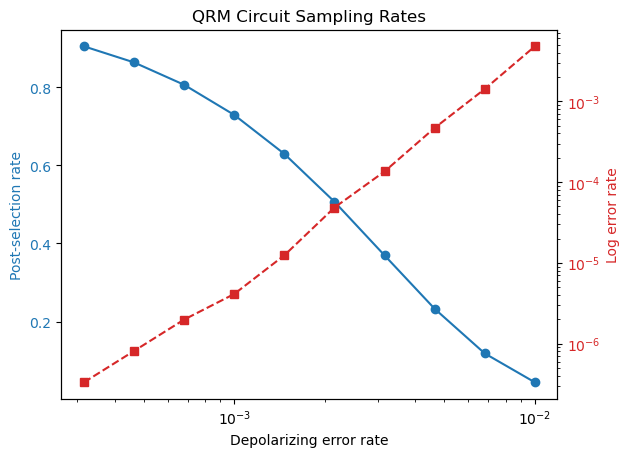

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Depolarizing error rate')
ax1.set_ylabel('Post-selection rate', color=color)
ax1.plot(error_rates, post_selection_rates, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Log error rate', color=color)
ax2.plot(error_rates, log_error_rates, 's--', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

plt.title('QRM Circuit Sampling Rates')
plt.show()

In [9]:
import numpy as np
import stim
from pymatching import Matching

def normalize_pred_shape(pred: np.ndarray, n: int, num_obs: int) -> np.ndarray:
    """
    Ensure predictions are shaped (n, num_obs) even when num_obs == 1.
    """
    pred = np.asarray(pred)
    if pred.ndim == 1:
        # Common gotcha with a single observable.
        if pred.shape[0] == n and num_obs == 1:
            pred = pred.reshape(n, 1)
        elif pred.shape[0] == num_obs and n == 1:
            pred = pred.reshape(1, num_obs)
        else:
            raise ValueError(f"Unexpected prediction shape {pred.shape} for n={n}, num_obs={num_obs}")
    if pred.shape != (n, num_obs):
        raise ValueError(f"Expected predictions shape {(n, num_obs)} but got {pred.shape}")
    return pred.astype(np.uint8, copy=False)

def run_with_pymatching(
    circuit: stim.Circuit,
    *,
    attempts: int,
    postselection_mask: np.ndarray | None = None,
    chunk_size: int = 100_000,
):
    """
    Simulates `attempts` shots, postselects on detectors in `postselection_mask`,
    and decodes kept shots with PyMatching.

    Returns a dict with:
        - attempted, kept, discards, postselection_rate
        - gt_logical_rate_cond_ps: ground-truth logical flip rate among kept shots (per observable)
        - decoder_error_rate_cond_ps: decoder error rate among kept shots (per observable)
    """
    num_d = circuit.num_detectors
    num_o = circuit.num_observables

    if postselection_mask is None:
        postselection_mask = np.ones(num_d, dtype=bool)
    else:
        postselection_mask = np.asarray(postselection_mask, dtype=bool)
        if postselection_mask.shape != (num_d,):
            raise ValueError(f"postselection_mask must have shape ({num_d},)")

    # Build decoder from DEM.
    dem = circuit.detector_error_model()
    assert dem.num_detectors == num_d, "DEM detectors != circuit detectors"
    assert dem.num_observables == num_o, "DEM observables != circuit observables"
    pm = Matching.from_detector_error_model(dem)

    # Sampler for paired detectors/observables.
    sampler = circuit.compile_detector_sampler()

    attempted = 0
    kept = 0
    discards = 0

    # Accumulators for conditional stats.
    gt_flip_counts_cond = np.zeros(num_o, dtype=np.int64) if num_o else None
    dec_err_counts_cond = np.zeros(num_o, dtype=np.int64) if num_o else None

    remaining = attempts
    while remaining > 0:
        n = min(chunk_size, remaining)
        dets, obs = sampler.sample(n, separate_observables=True)  # shapes: (n, num_d), (n, num_o)

        # Postselection: keep shots with no selected detection events.
        if postselection_mask.any():
            keep_mask = ~np.any(dets[:, postselection_mask], axis=1)
        else:
            keep_mask = np.ones(n, dtype=bool)

        k = int(np.count_nonzero(keep_mask))
        attempted += n
        kept += k
        discards += (n - k)

        if num_o and k > 0:
            # Decode only kept shots (so decoder "does nothing" if you keep only all-zero syndromes).
            kept_synd = dets[keep_mask, :].astype(np.uint8, copy=False)
            kept_obs = obs[keep_mask, :].astype(np.uint8, copy=False)

            pred = pm.decode_batch(kept_synd)
            pred = normalize_pred_shape(pred, n=k, num_obs=num_o)

            # Ground-truth logical flip rate among kept shots
            gt_flip_counts_cond += np.sum(kept_obs, axis=0, dtype=np.int64)

            # Decoder error rate among kept shots (XOR predicted vs ground truth)
            dec_err_counts_cond += np.sum(pred ^ kept_obs, axis=0, dtype=np.int64)

        remaining -= n

    ps_rate = kept / attempted if attempted else float('nan')

    if num_o and kept > 0:
        gt_ler_cond = gt_flip_counts_cond / kept
        dec_ler_cond = dec_err_counts_cond / kept
    else:
        gt_ler_cond = np.full((num_o,), np.nan, dtype=float)
        dec_ler_cond = np.full((num_o,), np.nan, dtype=float)

    return {
        'attempted': attempted,
        'kept': kept,
        'discards': discards,
        'postselection_rate': ps_rate,
        'gt_logical_rate_cond_ps': gt_ler_cond,
        'decoder_error_rate_cond_ps': dec_ler_cond,
    }

In [10]:
error_rates = [10**(x) for x in np.linspace(-3.5, -2, 10)]
post_selection_rates = []
log_error_rates = []
for error_rate in error_rates:
    circuit = qrm_circuit_flag(error_rate)
    stats = run_with_pymatching(circuit, attempts=int(1e7))
    post_selection_rates.append(stats['postselection_rate'])
    log_error_rates.append(stats['decoder_error_rate_cond_ps'])

print(log_error_rates, post_selection_rates)

[array([2.21003828e-07]), array([1.04218462e-06]), array([8.67942757e-07]), array([4.25075506e-06]), array([1.4138845e-05]), array([4.35813626e-05]), array([0.00013555]), array([0.00047714]), array([0.00140837]), array([0.00483523])] [0.9049617, 0.8635706, 0.8065048, 0.7292822, 0.6294715, 0.5070975, 0.3695945, 0.2324248, 0.1182217, 0.0442378]


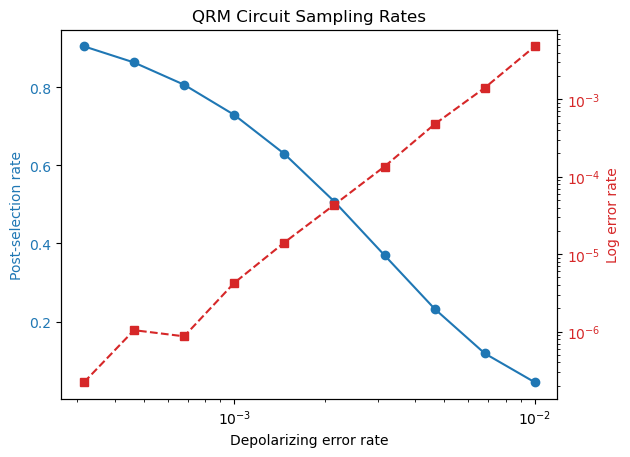

In [11]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Depolarizing error rate')
ax1.set_ylabel('Post-selection rate', color=color)
ax1.plot(error_rates, post_selection_rates, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Log error rate', color=color)
ax2.plot(error_rates, log_error_rates, 's--', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

plt.title('QRM Circuit Sampling Rates')
plt.show()

In [22]:
import sinter
from typing import List


tasks = [
    sinter.Task(
        circuit = qrm_circuit_flag(noise),
        postselection_mask = make_postselection_mask(30, list(range(30))),
        json_metadata={'noise': noise}
    )
    for noise in [10**(x) for x in np.linspace(-3.5, -2, 10)]
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=16,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=100_000_000,
    max_errors=5000,
)

/var/folders/7j/yz8g10ld5n54t45czpzxpd180000gn/T/ipykernel_88555/3864451513.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


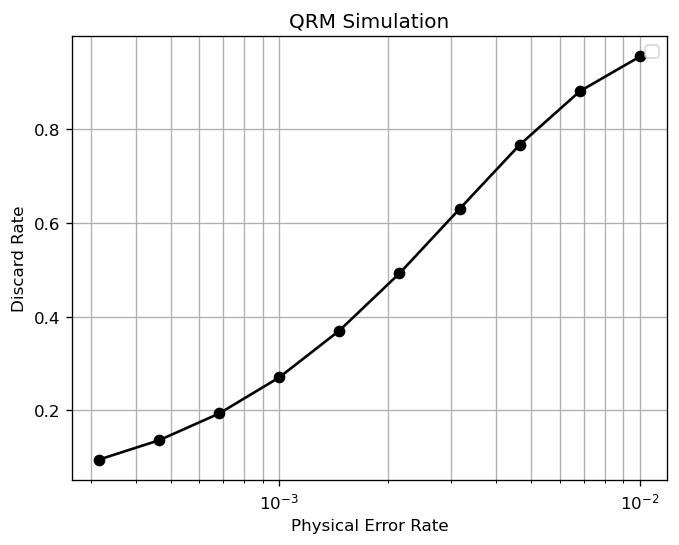

In [23]:
fig, ax = plt.subplots(1, 1)
sinter.plot_discard_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['noise'],
)
# ax.set_ylim(1e-6, 5e-1)
# ax.set_xlim(5e-4, 1e-2)
ax.set_title("QRM Simulation")
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Discard Rate")
ax.set_xscale("log")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

/var/folders/7j/yz8g10ld5n54t45czpzxpd180000gn/T/ipykernel_88555/2566049123.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


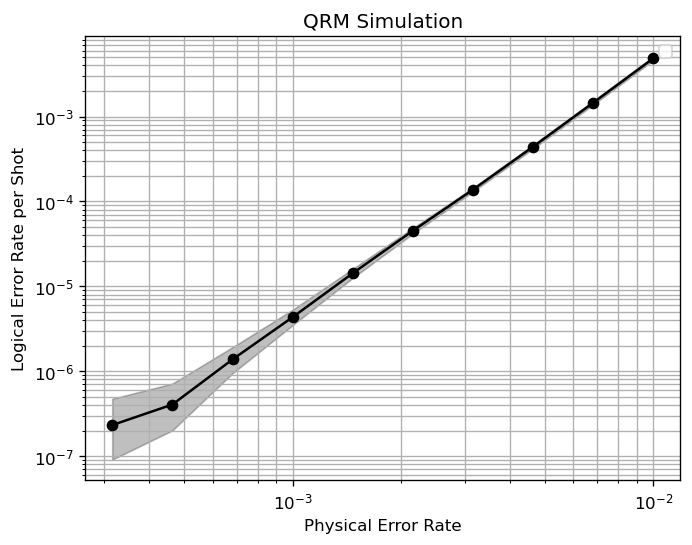

In [24]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['noise'],
)
# ax.set_ylim(1e-6, 5e-1)
# ax.set_xlim(5e-4, 1e-2)
ax.loglog()
ax.set_title("QRM Simulation")
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger